In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

### Herdando da classe keras.models.Model.

Neste exemplo iremos definir e criar uma instância da classe `WideAndDeepModel`, que nos dá um modelo equivalente ao que construímos com a API Funcional (figura abaixo). 

<img src="../../../../figures/rna_com_multiplas_saidas.png" width="300px">

Depois de instanciado um objeto desta classe, podemos então compilá-lo, avaliá-lo e usá-lo para fazer predições, exatamente como acabamos de fazer com o modelo criado com a API funcional.

### Carregando o conjunto de dados para regressão. 

+ Vamos usar o conjunto de dados habitacional da Califórnia e criar um regressor com uma rede neural.


+ Depois de carregar os dados, dividimos em um conjunto de treinamento, um conjunto de validação e um conjunto de teste, e padronizamos todos os atributos.

In [3]:
# Baixa a base de dados.
housing = fetch_california_housing()

# Divide o conjunto total de exemplos em conjuntos de treinamento e teste.
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)

# Divide o conjunto de treinamento em conjuntos de treinamento (menor) e validação.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# Aplica padronização às matrizes de atributos.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Definição da classe `WideAndDeepModel`.

+ A classe `WideAndDeepModel` herda de `keras.models.Model`.
+ No construtor, criamos todas as camadas necessárias.
+ No método `call`, realizamos a conexão das várias camadas.


**OSB**.: Este exemplo se parece muito com o que utilizou a **API funcional**, exceto que **não é necessário instanciar as entradas** (objetos da classe `Input`), apenas usamos o parâmetro `inputs` passado para o método `call()` e separamos a criação das camadas no construtor (`__init__`) de seu uso no método `call()`.

In [4]:
class WideAndDeepModel(keras.models.Model):
    
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # lida com parâmetros padrão como, por exemplo, name.
        self.hidden1 = keras.layers.Dense(units, activation=activation, name="main_output")
        self.hidden2 = keras.layers.Dense(units, activation=activation, name="aux_output")
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

### Instanciando um objeto da classe `WideAndDeepModel`.

In [5]:
model = WideAndDeepModel()

### Compilando o modelo.

**OBS**.:

+ A mesma função de perda é usada para ambas as saídas.
+ Pesos diferentes para cada função de custo.
+ Instanciamos um objeto da classe SGD para que possamos alterar o valor do passo de aprendizagem.

In [6]:
model.compile(loss="mse", 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

### Separando os atributos e treinando o modelo.

+ As matrizes de atributos A contém os atributos de 0 à 4 e as matrizes de atributos B, os atributos de 2 à 7.

In [7]:
# Separando os atributos.
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B   = X_test[:, :5],  X_test[:, 2:]

# Treinando o modelo.
history = model.fit([X_train_A, X_train_B], 
                    [y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
                   )

Epoch 1/20
363/363 [==============================] - 3s 5ms/step - loss: 2.1365 - output_1_loss: 1.9196 - output_2_loss: 4.0890 - val_loss: 1.6233 - val_output_1_loss: 0.8468 - val_output_2_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.8905 - output_1_loss: 0.6969 - output_2_loss: 2.6326 - val_loss: 1.5163 - val_output_1_loss: 0.6836 - val_output_2_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7429 - output_1_loss: 0.6088 - output_2_loss: 1.9499 - val_loss: 1.4639 - val_output_1_loss: 0.6229 - val_output_2_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6771 - output_1_loss: 0.5691 - output_2_loss: 1.6485 - val_loss: 1.3388 - val_output_1_loss: 0.5481 - val_output_2_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6381 - output_1_loss: 0.5434 - output_2_loss: 1.4911 - val_loss: 1.2177 - val_output_1_loss: 0.5194 - val_ou

### Resumo do modelo

O método `summary()` só funciona após termos passado dados através do modelo.


Apenas assim o framework consegue inspecionar o modelo e definir as entradas e saídas, mas mesmo assim, não temos informação sobre as dimensões das saídas de cada camada.

In [8]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_output (Dense)         multiple                  210       
                                                                 
 aux_output (Dense)          multiple                  930       
                                                                 
 dense (Dense)               multiple                  36        
                                                                 
 dense_1 (Dense)             multiple                  31        
                                                                 
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


### Histórico de perda do modelo.

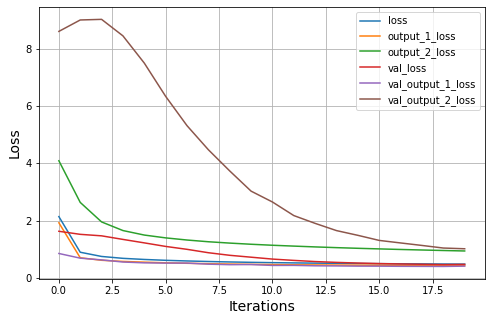

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

### Avaliando o modelo.

In [10]:
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

162/162 [==============================] - 0s 3ms/step - loss: 0.4668 - output_1_loss: 0.4178 - output_2_loss: 0.9082


### Realizando predições com o modelo.

Da mesma forma, o método `predict()` **retornará previsões para cada saída**.

Testamos com os 3 primeiros exemplos do conjunto de teste.

In [11]:
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 195ms/step


In [12]:
for i in range(len(y_pred_main)):
    print('Actual: %1.3f - Predicted main: %1.3f - Predicted aux: %1.3f' % (y_test[i], y_pred_main[i], y_pred_aux[i]))

Actual: 0.477 - Predicted main: 0.268 - Predicted aux: 0.959
Actual: 0.458 - Predicted main: 1.981 - Predicted aux: 1.924
Actual: 5.000 - Predicted main: 3.340 - Predicted aux: 2.515
